# Quiz One - Ruchita Raghunandan
### INFO 3440 | February 15, 2023

## Instructions:
Solve all problems in python to the best of your ability. You are welcome to use Excel in order to check your answers, but you must submit a python notebook exported as an html file to receive full credit. Furthermore, feel free to collaborate with your fellow classmates. You need to turn in your own copy of the notebook. All figures must contain your name in the title in order to receive full credit. 

### Due Date: Wednesday, February 15 2023 at 11.59pm

# Urbaczewski's Ski Boots<a id=1></a>

We are revisiting a transshipment problem similar to one that we solved in the second class of Week 2. In this problem, Elmore's Ski Boots is the manufacturer of the finest ski boots available. There are three plants that manufacture the boots, two distribution centers, and five warehouses. We need to ship the boots to the warehouses at a minimum cost satisfying the constraints outlined in the spreadsheet. Namely, each plant can only produce so much product, the amount of boots passing through the distribution centers has to remain constant (in has to equal out), and each warehouse has a minimum amount that they need in order to satisfy demand. The data are given in the Excel file `quiz-1.xlsx`.

## Solve the following problems. 
1. What is the minimum cost to ship these boots from our plants to the warehouses while satisfying all of our constraints? 
2. What are the final values of the decision variables?
3. Is there any slack in the system? If so, what is the amount/route that shows slack?
4. Suppose management tells us that the per unit shipping cost from Plant P3 to Distribution Center D1 is going to change to \$.60. How do your answers to 1. and 2. change? 
5. Show the values of the decision variables as barcharts using `seaborn`. Create a separate plot for Plants to Distribution Centers (colored by DCs) and another for DCs to Warehouses (colored by WHs).
6. Create a sequence of shipping costs (P3 to D1) from 0.5 to 0.7 in one cent increments (21 unique values). 

    a. Make a plot showing how the overall shipping costs change as a function of this sequence.
    
    b. Make two plots showing: (1) the amount of boots shipped between Plant P3 and the two distribution centers and (2) the amount of boots shipped between each distribution center and the five warehouses. The lines be shown using different colors. 
    
7. Finally, let's investigate how changing the demand on the third warehouse changes the final value of the objective function. Create a sequence of demands from 4700 to 7300 by 100 units. Plots those demands on the x axis and the final minimum cost on the y.

##### [Back to Top](#Top)

### Import Modules<a id=2></a>

In [213]:
import pandas as pd 
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

### Read and convert data

In [214]:
xlsx_file = pd.ExcelFile('quiz-1.xlsx')
xlsx_file.sheet_names

["Urbaczewski's Ski Boots", 'Coef', 'RHS']

#### SOLVING A MODEL AND DATA SETUP

In [215]:
# Creating cost coefficients for plants to distribution centers
cost1 = pd.read_excel(xlsx_file, sheet_name = 'Coef', index_col = 0, usecols = [0,1,2])
cost1

D1    D2
(From) Plant            
P1            0.50  0.60
P2            0.65  0.65
P3            0.63  0.78

In [216]:
# Creating cost coefficients for distribution centers to warehouses
cost2 = pd.read_excel(xlsx_file, sheet_name = 'Coef', index_col = 0, usecols = [4,5,6,7,8,9], nrows = 2)
cost2

W1   W2   W3   W4    W5
(From) DC                          
D1         0.5  0.4  0.3  0.5  0.72
D2         0.7  0.6  0.2  0.5  0.55

In [217]:
# Creating dataframe for demand requirements
demand = pd.read_excel(xlsx_file, sheet_name = 'RHS', index_col = 0, usecols = [2,3], nrows = 5)
demand

Requirement
W1         5000
W2         7500
W3         6000
W4         5500
W5         6250

In [218]:
# Creating dataframe for capacity constraints
capacity = pd.read_excel(xlsx_file, sheet_name = 'RHS', index_col = 0, usecols = [0,1], nrows = 3)
capacity

Capacity
P1     10000
P2     11000
P3     10500

In [219]:
# Creating the model
model = pe.ConcreteModel()

In [220]:
# Setting two sets of decision variables
DV1_indexes = ['D1', 'D2']
model.P1 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
model.P2 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
model.P3 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)

DV2_indexes = ['W1', 'W2', 'W3', 'W4', 'W5']
model.D1 = pe.Var(DV2_indexes, domain = pe.NonNegativeReals)
model.D2 = pe.Var(DV2_indexes, domain = pe.NonNegativeReals)

model.pprint()

5 Set Declarations
    D1_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'W1', 'W2', 'W3', 'W4', 'W5'}
    D2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'W1', 'W2', 'W3', 'W4', 'W5'}
    P1_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}
    P2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}
    P3_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}

5 Var Declarations
    D1 : Size=5, Index=D1_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         W1 :     0 :  None :  None : False :  True : NonNegativeReals
 

In [221]:
# Setting the expression/formula for the objective function.
model.obj = pe.Objective(expr = sum([cost1.loc['P1', index]*model.P1[index] for index in DV1_indexes] +
                         [cost1.loc['P2', index]*model.P2[index] for index in DV1_indexes] +
                         [cost1.loc['P3', index]*model.P3[index] for index in DV1_indexes] +
                         [cost2.loc['D1', index]*model.D1[index] for index in DV2_indexes] +
                         [cost2.loc['D2', index]*model.D2[index] for index in DV2_indexes]),
                         sense = pe.minimize)

In [222]:
# Displaying the objective function
model.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 0.5*P1[D1] + 0.6*P1[D2] + 0.65*P2[D1] + 0.65*P2[D2] + 0.63*P3[D1] + 0.78*P3[D2] + 0.5*D1[W1] + 0.4*D1[W2] + 0.3*D1[W3] + 0.5*D1[W4] + 0.72*D1[W5] + 0.7*D2[W1] + 0.6*D2[W2] + 0.2*D2[W3] + 0.5*D2[W4] + 0.55*D2[W5]


In [223]:
#Capacity Constraints
model.con_P1 = pe.Constraint(expr = sum(model.P1[index] for index in DV1_indexes) 
                              <= capacity.loc['P1','Capacity'])
model.con_P2 = pe.Constraint(expr = sum(model.P2[index] for index in DV1_indexes)
                              <= capacity.loc['P2','Capacity'])
model.con_P3 = pe.Constraint(expr = sum(model.P3[index] for index in DV1_indexes)
                              <= capacity.loc['P3','Capacity'])   
#Demand Constraints
model.con_W1 = pe.Constraint(expr = model.D1['W1'] + model.D2['W1'] 
                               >= demand.loc['W1','Requirement'])
model.con_W2 = pe.Constraint(expr = model.D1['W2'] + model.D2['W2'] 
                               >= demand.loc['W2','Requirement'])
model.con_W3 = pe.Constraint(expr = model.D1['W3'] + model.D2['W3'] 
                               >= demand.loc['W3','Requirement'])
model.con_W4 = pe.Constraint(expr = model.D1['W4'] + model.D2['W4'] 
                               >= demand.loc['W4','Requirement'])
model.con_W5 = pe.Constraint(expr = model.D1['W5'] + model.D2['W5'] 
                               >= demand.loc['W5','Requirement'])

# Flow Constraint
model.con_D1 = pe.Constraint(expr = model.P1['D1'] + model.P2['D1'] + model.P3['D1']
                             == sum(model.D1[index2] for index2 in DV2_indexes))
model.con_D2 = pe.Constraint(expr = model.P1['D2'] + model.P2['D2'] + model.P3['D2']
                             == sum(model.D2[index2] for index2 in DV2_indexes))


In [224]:
# Displaying samples of the constraints
model.con_P1.pprint()
model.con_W1.pprint()
model.con_D1.pprint()

con_P1 : Size=1, Index=None, Active=True
    Key  : Lower : Body            : Upper   : Active
    None :  -Inf : P1[D1] + P1[D2] : 10000.0 :   True
con_W1 : Size=1, Index=None, Active=True
    Key  : Lower  : Body            : Upper : Active
    None : 5000.0 : D1[W1] + D2[W1] :  +Inf :   True
con_D1 : Size=1, Index=None, Active=True
    Key  : Lower : Body                                                                    : Upper : Active
    None :   0.0 : P1[D1] + P2[D1] + P3[D1] - (D1[W1] + D1[W2] + D1[W3] + D1[W4] + D1[W5]) :   0.0 :   True


In [225]:
# Solving the model
opt = pe.SolverFactory('glpk')
result = opt.solve(model)
print(result.solver.status, result.solver.termination_condition)

ok optimal


In [226]:
# Displaying the model
model.display()

Model unknown

  Variables:
    P1 : Size=2, Index=P1_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
         D1 :     0 : 10000.0 :  None : False : False : NonNegativeReals
         D2 :     0 :     0.0 :  None : False : False : NonNegativeReals
    P2 : Size=2, Index=P2_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
         D1 :     0 :     0.0 :  None : False : False : NonNegativeReals
         D2 :     0 : 11000.0 :  None : False : False : NonNegativeReals
    P3 : Size=2, Index=P3_index
        Key : Lower : Value  : Upper : Fixed : Stale : Domain
         D1 :     0 : 9250.0 :  None : False : False : NonNegativeReals
         D2 :     0 :    0.0 :  None : False : False : NonNegativeReals
    D1 : Size=5, Index=D1_index
        Key : Lower : Value  : Upper : Fixed : Stale : Domain
         W1 :     0 : 5000.0 :  None : False : False : NonNegativeReals
         W2 :     0 : 7500.0 :  None : False : False : NonNegativeReals
         W3 : 

In [227]:
# Displaying the optimal objective function
obj_val = model.obj.expr()
print(f'optimal objective value minimum cost = ${obj_val:.2f}')

optimal objective value minimum cost = $30990.00


#### Problem 1

In [228]:
# What is the minimum cost to ship these boots from our plants to the warehouses while satisfying all of our constraints?
print(f'The minimum cost to ship boots from plants to the warehouses, given all the constraints, is ${obj_val:.2f}')

The minimum cost to ship boots from plants to the warehouses, given all the constraints, is $30990.00


#### Problem 2

In [229]:
# What are the final values of the decision variables?
DV_solution = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for var in DV:
        DV_solution.loc[DV.name, var] = DV[var].value
DV_solution

D1       D2      W1      W2      W3      W4      W5
P1  10000.0      0.0     NaN     NaN     NaN     NaN     NaN
P2      0.0  11000.0     NaN     NaN     NaN     NaN     NaN
P3   9250.0      0.0     NaN     NaN     NaN     NaN     NaN
D1      NaN      NaN  5000.0  7500.0  1250.0  5500.0     0.0
D2      NaN      NaN     0.0     0.0  4750.0     0.0  6250.0

#### Problem 3

In [230]:
# Is there any slack in the system? If so, what is the amount/route that shows slack?
print(f'Plant 1 Capacity slack = {model.con_P1.slack()}')
print(f'Plant 2 Capacity slack = {model.con_P2.slack()}')
print(f'Plant 3 Capacity slack = {model.con_P3.slack()}')
print(f'Warehouse 1 Capacity slack = {model.con_W1.slack()}')
print(f'Warehouse 2 Capacity slack = {model.con_W2.slack()}')
print(f'Warehouse 3 Capacity slack = {model.con_W3.slack()}')
print(f'Warehouse 4 Capacity slack = {model.con_W4.slack()}')
print(f'Warehouse 5 Capacity slack = {model.con_W5.slack()}')
print("The slack that we observe is on the route from Plant 3 to Distribution Centers, 1250 units.")

Plant 1 Capacity slack = 0.0
Plant 2 Capacity slack = 0.0
Plant 3 Capacity slack = 1250.0
Warehouse 1 Capacity slack = 0.0
Warehouse 2 Capacity slack = 0.0
Warehouse 3 Capacity slack = 0.0
Warehouse 4 Capacity slack = 0.0
Warehouse 5 Capacity slack = 0.0
The slack that we observe is on the route from Plant 3 to Distribution Centers, 1250 units.


#### Problem 4

In [231]:
# Suppose management tells us that the per unit shipping cost from Plant P3 to Distribution Center D1 is going to 
# change to $.60. How do your answers to 1. and 2. change?

##QUESTION 4 IS ANSWERED AT THE END SINCE A PORTION OF THE MODEL IS CHANGED AND COULD POTENTIALLY AFFECT PROBLEM 5,6,7.

#### Problem 5

In [232]:
# Show the values of the decision variables as barcharts using seaborn. 
# Create a separate plot for Plants to Distribution Centers (colored by DCs) and 
# another for DCs to Warehouses (colored by WHs).
   
# Creating dataframe for all decision variables
DV_solution = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for var in DV:
        DV_solution.loc[DV.name, var] = DV[var].value
DV_solution

D1       D2      W1      W2      W3      W4      W5
P1  10000.0      0.0     NaN     NaN     NaN     NaN     NaN
P2      0.0  11000.0     NaN     NaN     NaN     NaN     NaN
P3   9250.0      0.0     NaN     NaN     NaN     NaN     NaN
D1      NaN      NaN  5000.0  7500.0  1250.0  5500.0     0.0
D2      NaN      NaN     0.0     0.0  4750.0     0.0  6250.0

In [233]:
# Creating dataframe for extracting plants to distribution center variables
PtoD = pd.DataFrame(DV_solution, columns = ['D1', 'D2'], index = ['P1', 'P2', 'P3'])
plt=['P1', 'P2', 'P3']
PtoD['plant'] = plt
PtoD

D1       D2 plant
P1  10000.0      0.0    P1
P2      0.0  11000.0    P2
P3   9250.0      0.0    P3

<AxesSubplot:title={'center':'Units Shipped Plants to DCs'}, xlabel='plant', ylabel='Units'>

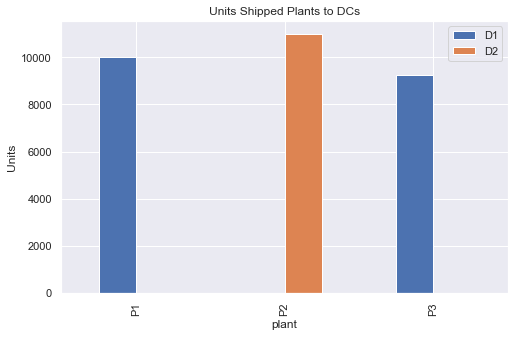

In [234]:
# Graph for units shipped from all three plants to distribution centers.
PtoD.set_index('plant').plot(kind='bar', title = 'Units Shipped Plants to DCs', ylabel = 'Units')

In [235]:
# Creating dataframe for extracting distribution center to warehouses variables
DtoW = pd.DataFrame(DV_solution, columns = ['W1', 'W2', 'W3', 'W4', 'W5'], index = ['D1', 'D2'])
dc = ['D1', 'D2']
DtoW['DCs'] = dc
DtoW

W1      W2      W3      W4      W5 DCs
D1  5000.0  7500.0  1250.0  5500.0     0.0  D1
D2     0.0     0.0  4750.0     0.0  6250.0  D2

<AxesSubplot:title={'center':'Units Shipped DCs to Warehouses'}, xlabel='DCs', ylabel='Units'>

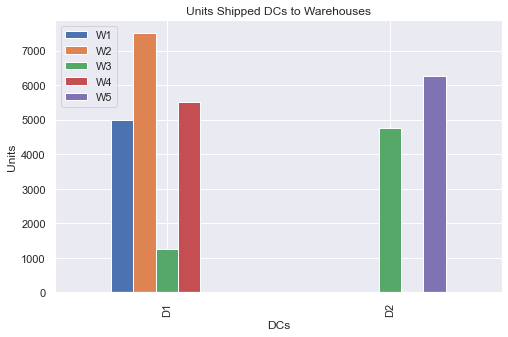

In [236]:
# Graph for units shipped from both distribution center to warehouses.
DtoW.set_index('DCs').plot(kind='bar', title = 'Units Shipped DCs to Warehouses', ylabel = 'Units')

#### Problem 6a

In [237]:
# Create a sequence of shipping costs (P3 to D1) from 0.5 to 0.7 in one cent increments (21 unique values).
# Make a plot showing how the overall shipping costs change as a function of this sequence.

# Creating increments from 0.5 to 0.7 as a list
P3_D1_costs = [(i + 50)/100 for i in list(range(0, 21))]
P3_D1_costs

[0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7]

In [238]:
# Defining run model and return model for future calculations
def run_model():
    #Once we solve the model we return the model object so we can get the optimal obj function value
    model = pe.ConcreteModel()
    #Decision Variables
    DV1_indexes = ['D1', 'D2']
    model.P1 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
    model.P2 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
    model.P3 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
    DV2_indexes = ['W1', 'W2', 'W3', 'W4', 'W5']
    model.D1 = pe.Var(DV2_indexes, domain = pe.NonNegativeReals)
    model.D2 = pe.Var(DV2_indexes, domain = pe.NonNegativeReals)

    #Objective Function
    model.obj = pe.Objective(expr = sum([cost1.loc['P1', index]*model.P1[index] for index in DV1_indexes] +
                         [cost1.loc['P2', index]*model.P2[index] for index in DV1_indexes] +
                         [cost1.loc['P3', index]*model.P3[index] for index in DV1_indexes] +
                         [cost2.loc['D1', index]*model.D1[index] for index in DV2_indexes] +
                         [cost2.loc['D2', index]*model.D2[index] for index in DV2_indexes]),
                         sense = pe.minimize)
    #Capacity Constraints
    model.con_P1 = pe.Constraint(expr = sum(model.P1[index] for index in DV1_indexes) 
                              <= capacity.loc['P1','Capacity'])
    model.con_P2 = pe.Constraint(expr = sum(model.P2[index] for index in DV1_indexes)
                              <= capacity.loc['P2','Capacity'])
    model.con_P3 = pe.Constraint(expr = sum(model.P3[index] for index in DV1_indexes)
                              <= capacity.loc['P3','Capacity'])   
    #Demand Constraints
    model.con_W1 = pe.Constraint(expr = model.D1['W1'] + model.D2['W1'] 
                               >= demand.loc['W1','Requirement'])
    model.con_W2 = pe.Constraint(expr = model.D1['W2'] + model.D2['W2'] 
                               >= demand.loc['W2','Requirement'])
    model.con_W3 = pe.Constraint(expr = model.D1['W3'] + model.D2['W3'] 
                               >= demand.loc['W3','Requirement'])
    model.con_W4 = pe.Constraint(expr = model.D1['W4'] + model.D2['W4'] 
                               >= demand.loc['W4','Requirement'])
    model.con_W5 = pe.Constraint(expr = model.D1['W5'] + model.D2['W5'] 
                               >= demand.loc['W5','Requirement'])

    # Flow Constraint
    model.con_D1 = pe.Constraint(expr = model.P1['D1'] + model.P2['D1'] + model.P3['D1']
                             == sum(model.D1[index2] for index2 in DV2_indexes))
    model.con_D2 = pe.Constraint(expr = model.P1['D2'] + model.P2['D2'] + model.P3['D2']
                             == sum(model.D2[index2] for index2 in DV2_indexes))
    opt = pe.SolverFactory('glpk')
    opt.solve(model, tee=False) #solve model and supress output
    return model

In [239]:
# Creating another list of values - change in cost based on the increment list
obj_list_P3D1 = []
for val in P3_D1_costs:
    cost1.loc['P3','D1'] = val
    model = run_model()
    obj_list_P3D1.append(model.obj.expr())
obj_list_P3D1

[29725.0,
 29830.0,
 29935.0,
 30040.0,
 30145.0,
 30250.0,
 30342.5,
 30435.0,
 30527.5,
 30620.0,
 30712.5,
 30805.0,
 30897.5,
 30990.0,
 31082.5,
 31175.0,
 31267.5,
 31360.0,
 31452.5,
 31532.5,
 31612.5]

In [240]:
# Converting the lists to a combined dataframe
obj_df_P3D1 = pd.DataFrame(obj_list_P3D1, 
                         index = P3_D1_costs, 
                         columns = ['cost'])
obj_df_P3D1

cost
0.50  29725.0
0.51  29830.0
0.52  29935.0
0.53  30040.0
0.54  30145.0
0.55  30250.0
0.56  30342.5
0.57  30435.0
0.58  30527.5
0.59  30620.0
0.60  30712.5
0.61  30805.0
0.62  30897.5
0.63  30990.0
0.64  31082.5
0.65  31175.0
0.66  31267.5
0.67  31360.0
0.68  31452.5
0.69  31532.5
0.70  31612.5

In [241]:
# Creating a zipped list based on the above dataframe
zip_list =  list(zip(P3_D1_costs, obj_list_P3D1))
zip_list

[(0.5, 29725.0),
 (0.51, 29830.0),
 (0.52, 29935.0),
 (0.53, 30040.0),
 (0.54, 30145.0),
 (0.55, 30250.0),
 (0.56, 30342.5),
 (0.57, 30435.0),
 (0.58, 30527.5),
 (0.59, 30620.0),
 (0.6, 30712.5),
 (0.61, 30805.0),
 (0.62, 30897.5),
 (0.63, 30990.0),
 (0.64, 31082.5),
 (0.65, 31175.0),
 (0.66, 31267.5),
 (0.67, 31360.0),
 (0.68, 31452.5),
 (0.69, 31532.5),
 (0.7, 31612.5)]

In [242]:
# Final dataframe that shows objective function value based on different costs of plant 3 to Distribution Center 1
PtoDdf = pd.DataFrame(zip_list, columns = ['P3toD1', 'Cost'])
PtoDdf

P3toD1     Cost
0     0.50  29725.0
1     0.51  29830.0
2     0.52  29935.0
3     0.53  30040.0
4     0.54  30145.0
5     0.55  30250.0
6     0.56  30342.5
7     0.57  30435.0
8     0.58  30527.5
9     0.59  30620.0
10    0.60  30712.5
11    0.61  30805.0
12    0.62  30897.5
13    0.63  30990.0
14    0.64  31082.5
15    0.65  31175.0
16    0.66  31267.5
17    0.67  31360.0
18    0.68  31452.5
19    0.69  31532.5
20    0.70  31612.5

[Text(0.5, 1.0, 'Change in Final Cost (Based on P3 to DC1 cost)'),
 Text(0.5, 0, 'P3 to D1 unit cost Dollars'),
 Text(0, 0.5, 'Total Minimum cost in Dollars')]

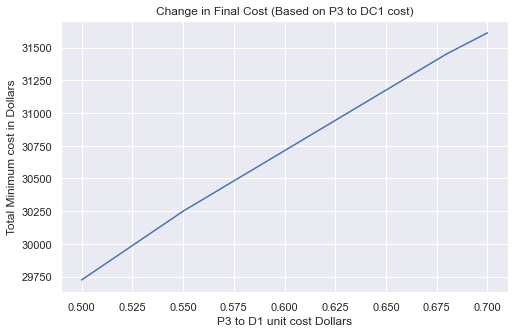

In [243]:
# Creating line plot for the above dataframe
sns.set(rc = {"figure.figsize":(8,5)})
sns.lineplot(x = 'P3toD1', y = 'Cost', data=PtoDdf).set(title = 'Change in Final Cost (Based on P3 to DC1 cost)', xlabel = 'P3 to D1 unit cost Dollars', ylabel = 'Total Minimum cost in Dollars')

#### Problem 6b

In [244]:
# b. Make two plots showing: 
# (1) the amount of boots shipped between Plant P3 and the two distribution centers and 
# (2) the amount of boots shipped between each distribution center and the five warehouses. 
# The lines be shown using different colors.

In [245]:
# Creating consolidated list of units from plants, distribution centers, warehouses and the objective function cost change
DV_list_P3D1=[]
for val in P3_D1_costs:
    DV_curr_list_P3D1 = []
    cost1.loc['P3','D1'] = val
    model = run_model()
    for DV in model.component_objects(pe.Var):
        for c in DV:
            DV_curr_list_P3D1.append(DV[c].value)
    DV_list_P3D1.append(DV_curr_list_P3D1)
print(DV_list_P3D1)

[[10000.0, 0.0, 0.0, 9750.0, 10500.0, 0.0, 5000.0, 7500.0, 2500.0, 5500.0, 0.0, 0.0, 0.0, 3500.0, 0.0, 6250.0], [10000.0, 0.0, 0.0, 9750.0, 10500.0, 0.0, 5000.0, 7500.0, 2500.0, 5500.0, 0.0, 0.0, 0.0, 3500.0, 0.0, 6250.0], [10000.0, 0.0, 0.0, 9750.0, 10500.0, 0.0, 5000.0, 7500.0, 2500.0, 5500.0, 0.0, 0.0, 0.0, 3500.0, 0.0, 6250.0], [10000.0, 0.0, 0.0, 9750.0, 10500.0, 0.0, 5000.0, 7500.0, 2500.0, 5500.0, 0.0, 0.0, 0.0, 3500.0, 0.0, 6250.0], [10000.0, 0.0, 0.0, 9750.0, 10500.0, 0.0, 5000.0, 7500.0, 2500.0, 5500.0, 0.0, 0.0, 0.0, 3500.0, 0.0, 6250.0], [10000.0, 0.0, 0.0, 9750.0, 10500.0, 0.0, 5000.0, 7500.0, 2500.0, 5500.0, 0.0, 0.0, 0.0, 3500.0, 0.0, 6250.0], [10000.0, 0.0, 0.0, 11000.0, 9250.0, 0.0, 5000.0, 7500.0, 1250.0, 5500.0, 0.0, 0.0, 0.0, 4750.0, 0.0, 6250.0], [10000.0, 0.0, 0.0, 11000.0, 9250.0, 0.0, 5000.0, 7500.0, 1250.0, 5500.0, 0.0, 0.0, 0.0, 4750.0, 0.0, 6250.0], [10000.0, 0.0, 0.0, 11000.0, 9250.0, 0.0, 5000.0, 7500.0, 1250.0, 5500.0, 0.0, 0.0, 0.0, 4750.0, 0.0, 6250.0], 

In [246]:
# Converting the above list to a dataframe and determining column headers
DV_col_names=['P1,D1','P1,D2','P2,D1','P2,D2','P3,D1','P3,D2', 'D1,W1', 'D1,W2', 'D1,W3', 'D1,W4', 'D1,W5', 'D2,W1', 'D2,W2', 'D2,W3', 'D2,W4', 'D2,W5']
DV_df_change = pd.DataFrame(DV_list_P3D1, columns = DV_col_names)
DV_df_change['Costs'] = P3_D1_costs
DV_df_change

P1,D1  P1,D2  P2,D1    P2,D2    P3,D1   P3,D2   D1,W1   D1,W2   D1,W3  \
0   10000.0    0.0    0.0   9750.0  10500.0     0.0  5000.0  7500.0  2500.0   
1   10000.0    0.0    0.0   9750.0  10500.0     0.0  5000.0  7500.0  2500.0   
2   10000.0    0.0    0.0   9750.0  10500.0     0.0  5000.0  7500.0  2500.0   
3   10000.0    0.0    0.0   9750.0  10500.0     0.0  5000.0  7500.0  2500.0   
4   10000.0    0.0    0.0   9750.0  10500.0     0.0  5000.0  7500.0  2500.0   
5   10000.0    0.0    0.0   9750.0  10500.0     0.0  5000.0  7500.0  2500.0   
6   10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
7   10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
8   10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
9   10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
10  10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
11  10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
12  10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
13  10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
14  10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
15  10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
16  10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
17  10000.0    0.0    0.0  11000.0   9250.0     0.0  5000.0  7500.0  1250.0   
18  10000.0    0.0    0.0  11000.0   8000.0  1250.0  5000.0  7500.0     0.0   
19  10000.0    0.0    0.0  11000.0   8000.0  1250.0  5000.0  7500.0     0.0   
20  10000.0    0.0    0.0  11000.0   8000.0  1250.0  5000.0  7500.0     0.0   

     D1,W4  D1,W5  D2,W1  D2,W2   D2,W3  D2,W4   D2,W5  Costs  
0   5500.0    0.0    0.0    0.0  3500.0    0.0  6250.0   0.50  
1   5500.0    0.0    0.0    0.0  3500.0    0.0  6250.0   0.51  
2   5500.0    0.0    0.0    0.0  3500.0    0.0  6250.0   0.52  
3   5500.0    0.0    0.0    0.0  3500.0    0.0  6250.0   0.53  
4   5500.0    0.0    0.0    0.0  3500.0    0.0  6250.0   0.54  
5   5500.0    0.0    0.0    0.0  3500.0    0.0  6250.0   0.55  
6   5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.56  
7   5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.57  
8   5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.58  
9   5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.59  
10  5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.60  
11  5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.61  
12  5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.62  
13  5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.63  
14  5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.64  
15  5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.65  
16  5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.66  
17  5500.0    0.0    0.0    0.0  4750.0    0.0  6250.0   0.67  
18  5500.0    0.0    0.0    0.0  6000.0    0.0  6250.0   0.68  
19  5500.0    0.0    0.0    0.0  6000.0    0.0  6250.0   0.69  
20  5500.0    0.0    0.0    0.0  6000.0    0.0  6250.0   0.70

In [247]:
# New dataframe by using melt feature on previous dataframe. Sets unique identifier.
DF_FINAL = pd.melt(DV_df_change, 'Costs')
DF_FINAL

Costs variable    value
0     0.50    P1,D1  10000.0
1     0.51    P1,D1  10000.0
2     0.52    P1,D1  10000.0
3     0.53    P1,D1  10000.0
4     0.54    P1,D1  10000.0
..     ...      ...      ...
331   0.66    D2,W5   6250.0
332   0.67    D2,W5   6250.0
333   0.68    D2,W5   6250.0
334   0.69    D2,W5   6250.0
335   0.70    D2,W5   6250.0

[336 rows x 3 columns]

In [248]:
# Adding indexes for creating graphs
DF_FINAL['source'] = DF_FINAL['variable'].str[:2]
DF_FINAL['source1'] = DF_FINAL['variable'].str[:1]
DF_FINAL

Costs variable    value source source1
0     0.50    P1,D1  10000.0     P1       P
1     0.51    P1,D1  10000.0     P1       P
2     0.52    P1,D1  10000.0     P1       P
3     0.53    P1,D1  10000.0     P1       P
4     0.54    P1,D1  10000.0     P1       P
..     ...      ...      ...    ...     ...
331   0.66    D2,W5   6250.0     D2       D
332   0.67    D2,W5   6250.0     D2       D
333   0.68    D2,W5   6250.0     D2       D
334   0.69    D2,W5   6250.0     D2       D
335   0.70    D2,W5   6250.0     D2       D

[336 rows x 5 columns]

[Text(0.5, 1.0, 'Units from P3 by Cost'),
 Text(0.5, 0, 'Cost in dollars'),
 Text(0, 0.5, 'Units')]

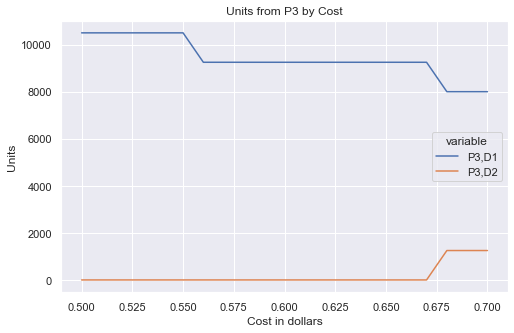

In [249]:
# Creating graph for units shipped from Plant 3
sns.set(rc = {"figure.figsize":(8,5)})
sns.lineplot(x = 'Costs', y = 'value', hue = 'variable', data=DF_FINAL[DF_FINAL.source == 'P3']).set(title = 'Units from P3 by Cost', xlabel = "Cost in dollars", ylabel = "Units")

[Text(0.5, 1.0, 'Units from DCs by Cost'),
 Text(0.5, 0, 'Cost in dollars'),
 Text(0, 0.5, 'Units')]

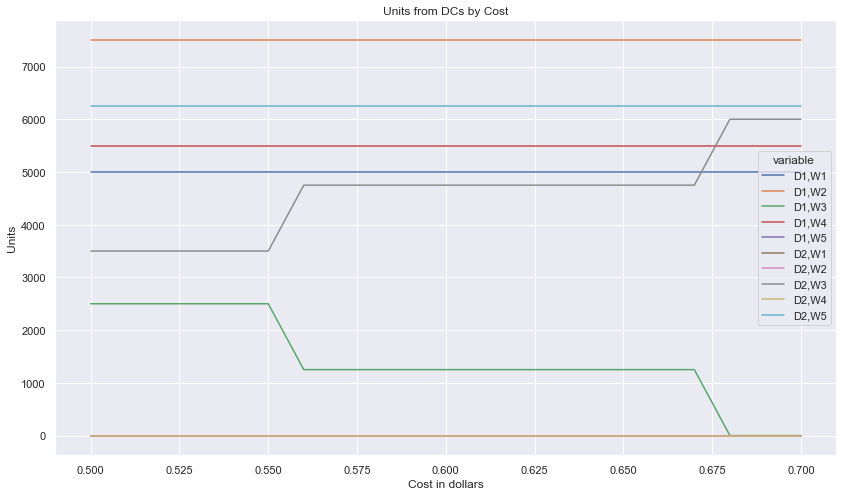

In [250]:
# Creating graph for units shipped from distribution centers
sns.set(rc = {"figure.figsize":(14,8)})
sns.lineplot(x = 'Costs', y = 'value', hue = 'variable', data=DF_FINAL[DF_FINAL.source1 == 'D']).set(title = 'Units from DCs by Cost', xlabel = "Cost in dollars", ylabel = "Units")

#### Problem 7

In [251]:
# Finally, let's investigate how changing the demand on the third warehouse 
# changes the final value of the objective function. 
# Create a sequence of demands from 4700 to 7200 by 100 units.
# Plots those demands on the x axis and the final minimum cost on the y.


# Display demand dataframe
demand

Requirement
W1         5000
W2         7500
W3         6000
W4         5500
W5         6250

In [252]:
# Creating list of increments for warehouse 3 demand
W3_demand = []
for i in range(4700, 7300, 100):
    W3_demand.append(i)
W3_demand

[4700,
 4800,
 4900,
 5000,
 5100,
 5200,
 5300,
 5400,
 5500,
 5600,
 5700,
 5800,
 5900,
 6000,
 6100,
 6200,
 6300,
 6400,
 6500,
 6600,
 6700,
 6800,
 6900,
 7000,
 7100,
 7200]

In [253]:
# Defining run model and return model for future calculations
def run_model():
    #Once we solve the model we return the model object so we can get the optimal obj function value
    model = pe.ConcreteModel()
    #Decision Variables
    DV1_indexes = ['D1', 'D2']
    model.P1 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
    model.P2 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
    model.P3 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
    DV2_indexes = ['W1', 'W2', 'W3', 'W4', 'W5']
    model.D1 = pe.Var(DV2_indexes, domain = pe.NonNegativeReals)
    model.D2 = pe.Var(DV2_indexes, domain = pe.NonNegativeReals)

    #Objective Function
    model.obj = pe.Objective(expr = sum([cost1.loc['P1', index]*model.P1[index] for index in DV1_indexes] +
                         [cost1.loc['P2', index]*model.P2[index] for index in DV1_indexes] +
                         [cost1.loc['P3', index]*model.P3[index] for index in DV1_indexes] +
                         [cost2.loc['D1', index]*model.D1[index] for index in DV2_indexes] +
                         [cost2.loc['D2', index]*model.D2[index] for index in DV2_indexes]),
                         sense = pe.minimize)
    #Capacity Constraints
    model.con_P1 = pe.Constraint(expr = sum(model.P1[index] for index in DV1_indexes) 
                              <= capacity.loc['P1','Capacity'])
    model.con_P2 = pe.Constraint(expr = sum(model.P2[index] for index in DV1_indexes)
                              <= capacity.loc['P2','Capacity'])
    model.con_P3 = pe.Constraint(expr = sum(model.P3[index] for index in DV1_indexes)
                              <= capacity.loc['P3','Capacity'])   
    #Demand Constraints
    model.con_W1 = pe.Constraint(expr = model.D1['W1'] + model.D2['W1'] 
                               >= demand.loc['W1','Requirement'])
    model.con_W2 = pe.Constraint(expr = model.D1['W2'] + model.D2['W2'] 
                               >= demand.loc['W2','Requirement'])
    model.con_W3 = pe.Constraint(expr = model.D1['W3'] + model.D2['W3'] 
                               >= demand.loc['W3','Requirement'])
    model.con_W4 = pe.Constraint(expr = model.D1['W4'] + model.D2['W4'] 
                               >= demand.loc['W4','Requirement'])
    model.con_W5 = pe.Constraint(expr = model.D1['W5'] + model.D2['W5'] 
                               >= demand.loc['W5','Requirement'])

    # Flow Constraint
    model.con_D1 = pe.Constraint(expr = model.P1['D1'] + model.P2['D1'] + model.P3['D1']
                             == sum(model.D1[index2] for index2 in DV2_indexes))
    model.con_D2 = pe.Constraint(expr = model.P1['D2'] + model.P2['D2'] + model.P3['D2']
                             == sum(model.D2[index2] for index2 in DV2_indexes))
    opt = pe.SolverFactory('glpk')
    opt.solve(model, tee=False) #solve model and supress output
    return model

In [254]:
# Creating another list of values - change in cost based on the increment list
obj_list_W3DD = []
for val in W3_demand:
    demand.loc['W3','Requirement'] = val
    model = run_model()
    obj_list_W3DD.append(model.obj.expr())
obj_list_W3DD

[30342.5,
 30436.5,
 30534.5,
 30632.5,
 30730.5,
 30828.5,
 30926.5,
 31024.5,
 31122.5,
 31220.5,
 31318.5,
 31416.5,
 31514.5,
 31612.5,
 31710.5,
 31808.5,
 31906.5,
 32004.5,
 32102.5,
 32200.5,
 32298.5,
 32396.5,
 32494.5,
 32592.5,
 32690.5,
 32788.5]

In [255]:
# Combining the lists above to a dataframe
obj_df_W3DD = pd.DataFrame(obj_list_W3DD, 
                         index = W3_demand, 
                         columns = ['cost'])
obj_df_W3DD

cost
4700  30342.5
4800  30436.5
4900  30534.5
5000  30632.5
5100  30730.5
5200  30828.5
5300  30926.5
5400  31024.5
5500  31122.5
5600  31220.5
5700  31318.5
5800  31416.5
5900  31514.5
6000  31612.5
6100  31710.5
6200  31808.5
6300  31906.5
6400  32004.5
6500  32102.5
6600  32200.5
6700  32298.5
6800  32396.5
6900  32494.5
7000  32592.5
7100  32690.5
7200  32788.5

In [256]:
# Dataframe converted to a zipped list
zip_list =  list(zip(W3_demand, obj_list_W3DD))
zip_list

[(4700, 30342.5),
 (4800, 30436.5),
 (4900, 30534.5),
 (5000, 30632.5),
 (5100, 30730.5),
 (5200, 30828.5),
 (5300, 30926.5),
 (5400, 31024.5),
 (5500, 31122.5),
 (5600, 31220.5),
 (5700, 31318.5),
 (5800, 31416.5),
 (5900, 31514.5),
 (6000, 31612.5),
 (6100, 31710.5),
 (6200, 31808.5),
 (6300, 31906.5),
 (6400, 32004.5),
 (6500, 32102.5),
 (6600, 32200.5),
 (6700, 32298.5),
 (6800, 32396.5),
 (6900, 32494.5),
 (7000, 32592.5),
 (7100, 32690.5),
 (7200, 32788.5)]

In [257]:
# Final dataframe created with warehouse 3 demand and objective function cost changes
W3DDdf = pd.DataFrame(zip_list, columns = ['W3_demand', 'cost'])
W3DDdf

W3_demand     cost
0        4700  30342.5
1        4800  30436.5
2        4900  30534.5
3        5000  30632.5
4        5100  30730.5
5        5200  30828.5
6        5300  30926.5
7        5400  31024.5
8        5500  31122.5
9        5600  31220.5
10       5700  31318.5
11       5800  31416.5
12       5900  31514.5
13       6000  31612.5
14       6100  31710.5
15       6200  31808.5
16       6300  31906.5
17       6400  32004.5
18       6500  32102.5
19       6600  32200.5
20       6700  32298.5
21       6800  32396.5
22       6900  32494.5
23       7000  32592.5
24       7100  32690.5
25       7200  32788.5

[Text(0.5, 1.0, 'Optimal minimum cost by W3 demand'),
 Text(0.5, 0, 'Units from W3'),
 Text(0, 0.5, 'Cost in Dollars')]

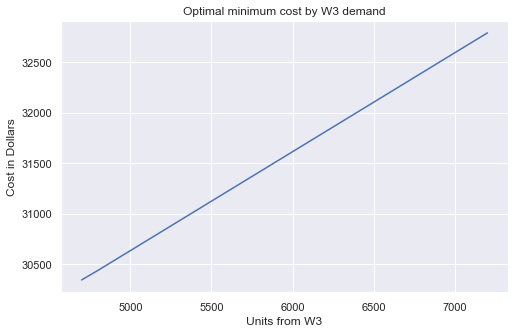

In [258]:
# Creating graph for how final cost changes with respect to change in warehouse 3 units demanded
sns.set(rc = {"figure.figsize":(8,5)})
sns.lineplot(x = 'W3_demand', y = 'cost', data=W3DDdf).set(title = 'Optimal minimum cost by W3 demand', xlabel = 'Units from W3', ylabel = 'Cost in Dollars')

### PROBLEM 4

In [261]:
# Suppose management tells us that the per unit shipping cost from Plant P3 to Distribution Center D1 is going to 
# change to $.60. How do your answers to 1. and 2. change?

# Replacing unit cost from $0.63 to $0.60 
# Please note if tried to replace the original 0.63, it shows 0.70 in the answer below. The replacement numbers had to be adjusted for this glitch.
cost1 = cost1.replace(0.70,0.60)
cost1

D1    D2
(From) Plant            
P1            0.50  0.60
P2            0.65  0.65
P3            0.60  0.78

In [262]:
# Creating the model
model = pe.ConcreteModel()

In [263]:
# Setting two sets of decision variables
DV1_indexes = ['D1', 'D2']
model.P1 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
model.P2 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)
model.P3 = pe.Var(DV1_indexes, domain = pe.NonNegativeReals)

DV2_indexes = ['W1', 'W2', 'W3', 'W4', 'W5']
model.D1 = pe.Var(DV2_indexes, domain = pe.NonNegativeReals)
model.D2 = pe.Var(DV2_indexes, domain = pe.NonNegativeReals)

model.pprint()

5 Set Declarations
    D1_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'W1', 'W2', 'W3', 'W4', 'W5'}
    D2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'W1', 'W2', 'W3', 'W4', 'W5'}
    P1_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}
    P2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}
    P3_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}

5 Var Declarations
    D1 : Size=5, Index=D1_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         W1 :     0 :  None :  None : False :  True : NonNegativeReals
 

In [264]:
# Setting the expression/formula for the objective function.
model.obj = pe.Objective(expr = sum([cost1.loc['P1', index]*model.P1[index] for index in DV1_indexes] +
                         [cost1.loc['P2', index]*model.P2[index] for index in DV1_indexes] +
                         [cost1.loc['P3', index]*model.P3[index] for index in DV1_indexes] +
                         [cost2.loc['D1', index]*model.D1[index] for index in DV2_indexes] +
                         [cost2.loc['D2', index]*model.D2[index] for index in DV2_indexes]),
                         sense = pe.minimize)

In [265]:
#Capacity Constraints
model.con_P1 = pe.Constraint(expr = sum(model.P1[index] for index in DV1_indexes) 
                              <= capacity.loc['P1','Capacity'])
model.con_P2 = pe.Constraint(expr = sum(model.P2[index] for index in DV1_indexes)
                              <= capacity.loc['P2','Capacity'])
model.con_P3 = pe.Constraint(expr = sum(model.P3[index] for index in DV1_indexes)
                              <= capacity.loc['P3','Capacity'])   
#Demand Constraints
model.con_W1 = pe.Constraint(expr = model.D1['W1'] + model.D2['W1'] 
                               >= demand.loc['W1','Requirement'])
model.con_W2 = pe.Constraint(expr = model.D1['W2'] + model.D2['W2'] 
                               >= demand.loc['W2','Requirement'])
model.con_W3 = pe.Constraint(expr = model.D1['W3'] + model.D2['W3'] 
                               >= demand.loc['W3','Requirement'])
model.con_W4 = pe.Constraint(expr = model.D1['W4'] + model.D2['W4'] 
                               >= demand.loc['W4','Requirement'])
model.con_W5 = pe.Constraint(expr = model.D1['W5'] + model.D2['W5'] 
                               >= demand.loc['W5','Requirement'])

# Flow Constraint
model.con_D1 = pe.Constraint(expr = model.P1['D1'] + model.P2['D1'] + model.P3['D1']
                             == sum(model.D1[index2] for index2 in DV2_indexes))
model.con_D2 = pe.Constraint(expr = model.P1['D2'] + model.P2['D2'] + model.P3['D2']
                             == sum(model.D2[index2] for index2 in DV2_indexes))

In [266]:
# Displaying samples of the constraints
model.con_P1.pprint()
model.con_W1.pprint()
model.con_D1.pprint()

con_P1 : Size=1, Index=None, Active=True
    Key  : Lower : Body            : Upper   : Active
    None :  -Inf : P1[D1] + P1[D2] : 10000.0 :   True
con_W1 : Size=1, Index=None, Active=True
    Key  : Lower  : Body            : Upper : Active
    None : 5000.0 : D1[W1] + D2[W1] :  +Inf :   True
con_D1 : Size=1, Index=None, Active=True
    Key  : Lower : Body                                                                    : Upper : Active
    None :   0.0 : P1[D1] + P2[D1] + P3[D1] - (D1[W1] + D1[W2] + D1[W3] + D1[W4] + D1[W5]) :   0.0 :   True


In [267]:
# Solving the model
opt = pe.SolverFactory('glpk')
result = opt.solve(model)
print(result.solver.status, result.solver.termination_condition)

ok optimal


In [268]:
# Displaying the model
model.display()

Model unknown

  Variables:
    P1 : Size=2, Index=P1_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
         D1 :     0 : 10000.0 :  None : False : False : NonNegativeReals
         D2 :     0 :     0.0 :  None : False : False : NonNegativeReals
    P2 : Size=2, Index=P2_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
         D1 :     0 :     0.0 :  None : False : False : NonNegativeReals
         D2 :     0 : 11000.0 :  None : False : False : NonNegativeReals
    P3 : Size=2, Index=P3_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
         D1 :     0 : 10450.0 :  None : False : False : NonNegativeReals
         D2 :     0 :     0.0 :  None : False : False : NonNegativeReals
    D1 : Size=5, Index=D1_index
        Key : Lower : Value  : Upper : Fixed : Stale : Domain
         W1 :     0 : 5000.0 :  None : False : False : NonNegativeReals
         W2 :     0 : 7500.0 :  None : False : False : NonNegativeReals
         W3

In [269]:
# Changes to questions 1 & 2
# Question 1 change
obj_val = model.obj.expr()
print(f'The minimum cost increase from $30,990. Even though this route showed a slack before, one of our constraints itself changed, which shifted the model objective. The new optimal objective value/minimum cost = ${obj_val:.2f}')

The minimum cost increase from $30,990. Even though this route showed a slack before, one of our constraints itself changed, which shifted the model objective. The new optimal objective value/minimum cost = $31792.50


In [270]:
# Question 2 change
DV_solution = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for var in DV:
        DV_solution.loc[DV.name, var] = DV[var].value
DV_solution

D1       D2      W1      W2      W3      W4      W5
P1  10000.0      0.0     NaN     NaN     NaN     NaN     NaN
P2      0.0  11000.0     NaN     NaN     NaN     NaN     NaN
P3  10450.0      0.0     NaN     NaN     NaN     NaN     NaN
D1      NaN      NaN  5000.0  7500.0  2450.0  5500.0     0.0
D2      NaN      NaN     0.0     0.0  4750.0     0.0  6250.0

In [271]:
print("Most of all decision variables/units shipped remain the same. However, because of lower cost, we're shipping more units from P3 to D1, 9250 increased to 10450. This also lead to more units going out of D1 to W4, 1250 to 2450.")

Most of all decision variables/units shipped remain the same. However, because of lower cost, we're shipping more units from P3 to D1, 9250 increased to 10450. This also lead to more units going out of D1 to W4, 1250 to 2450.
